In [1]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms as T
import os, shutil
from matplotlib import pyplot as plt
import sklearn as sk
from glob import glob
from tqdm import tqdm
from PIL import Image
import numpy as np
import torchmetrics
import timm
from time import time

In [2]:
import os, gdown 
from glob import glob
import shutil
def data_download(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "apple_disease", "insects", "cars", "crop",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils":         url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes":      url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac":         url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain":           url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits":          url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease":   url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles":        url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud":           url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects":         url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"       
    elif data_nomi == "cars":            url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion":     url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop":            url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"    
    elif data_nomi == "comments":        url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset" 
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_download(saqlash_uchun_papka = "datasets", data_nomi = "rice_leaf_disease")
data_path = "datasets/rice_leaf_disease/Rice Leaf  Disease Dataset"

Dataset yuklab olingan. datasets/rice_leaf_disease papkasini ni tekshiring.


### Custom Dataset

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_path, img_formats = [".jpg", ".jpeg", "bmp"], transformations = None):
        super().__init__()
        self.img_pathes = glob(f"{data_path}/*/*{[img_format for img_format in img_formats]}")
        self.transformations = transformations
        self.get_data_info()

    def __len__(self): return len(self.img_pathes)

    def get_data_info(self):
        numbering, self.class_names, self.data_quantity = 0, {}, {}
        
        for one_img_path in self.img_pathes:
            class_name = self.class_name_detection(one_img_path)
            
            if class_name not in self.class_names: 
                self.class_names[class_name] = numbering 
                numbering += 1
            
            if not class_name in self.data_quantity: 
                self.data_quantity[class_name] = 1
            else: self.data_quantity[class_name] += 1
        print(f"{self.class_names}\n\n")
        print(self.data_quantity)
        
        return self.class_names, self.data_quantity

    def class_name_detection(self, one_img_path):
        return os.path.basename(os.path.dirname(one_img_path))

    def __getitem__(self, idx):
        one_img_path = self.img_pathes[idx]
        class_name = self.class_name_detection(one_img_path)
        pic_name = self.class_names[class_name]
        pic = Image.open(one_img_path).convert("RGB")
        if self.transformations: pic = self.transformations(pic)
        return pic, pic_name

from torchvision import transforms as T
data_path = "datasets/rice_leaf_disease/Rice Leaf  Disease Dataset"
mean, std, img_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((img_size, img_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])
ds = CustomDataset(data_path = data_path, transformations = tfs)

print(len(ds))



{'Brown Spot': 0, 'False smut': 1, 'Healthy': 2, 'Material Leaf Blight': 3, 'Rice Blast': 4, 'sheath_blight': 5, 'Stem rot': 6, 'Tungro': 7}


{'Brown Spot': 51, 'False smut': 97, 'Healthy': 100, 'Material Leaf Blight': 45, 'Rice Blast': 54, 'sheath_blight': 98, 'Stem rot': 85, 'Tungro': 65}
595


### Creating Dataloaders

In [5]:
def create_dataloaders(data_path, transformations, bs, split = [0.8, 0.1]):

    ds = CustomDataset(data_path = data_path, transformations = tfs)
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle = False)
    ts_dl = DataLoader(ts_ds, batch_size = bs, shuffle = False)
    return tr_dl, vl_dl, ts_dl, ds.class_names

tr_dl, vl_dl, ts_dl, class_names = create_dataloaders(data_path = data_path, transformations = tfs, bs = 32  )
print(len(class_names))
# print(class_names)

for idx, pic in enumerate(ds):
    if idx == 1: break
    print(ds[idx])
print(f"train - {len(tr_dl)}")
print(f"val -   {len(vl_dl)}")
print(f"test - {len(ts_dl)}")


{'Brown Spot': 0, 'False smut': 1, 'Healthy': 2, 'Material Leaf Blight': 3, 'Rice Blast': 4, 'sheath_blight': 5, 'Stem rot': 6, 'Tungro': 7}


{'Brown Spot': 51, 'False smut': 97, 'Healthy': 100, 'Material Leaf Blight': 45, 'Rice Blast': 54, 'sheath_blight': 98, 'Stem rot': 85, 'Tungro': 65}
8
(tensor([[[ 0.8789,  0.9132,  0.9474,  ...,  0.9817,  0.9646,  0.9474],
         [ 0.1597,  0.1597,  0.1939,  ...,  0.2796,  0.2796,  0.2624],
         [ 0.1597,  0.1597,  0.1426,  ...,  0.2624,  0.2796,  0.2624],
         ...,
         [ 0.1597,  0.0912,  0.0569,  ..., -0.5253, -0.5767, -0.5424],
         [ 0.0912,  0.0741,  0.0398,  ..., -0.5082, -0.5938, -0.5938],
         [ 0.0398,  0.0227, -0.0116,  ..., -0.5767, -0.6109, -0.6109]],

        [[ 1.2381,  1.2906,  1.3256,  ...,  1.5357,  1.5182,  1.5007],
         [ 0.5378,  0.5378,  0.5728,  ...,  0.8880,  0.8880,  0.8704],
         [ 0.5553,  0.5553,  0.5903,  ...,  0.9230,  0.9230,  0.9055],
         ...,
         [ 0.9580,  0.9405,  0.8880

In [6]:
print(len(ts_dl.dataset))
print(len(vl_dl.dataset))
print(len(tr_dl.dataset))
476%32 #checking length of mini batch size

60
59
476


28

### Visualization

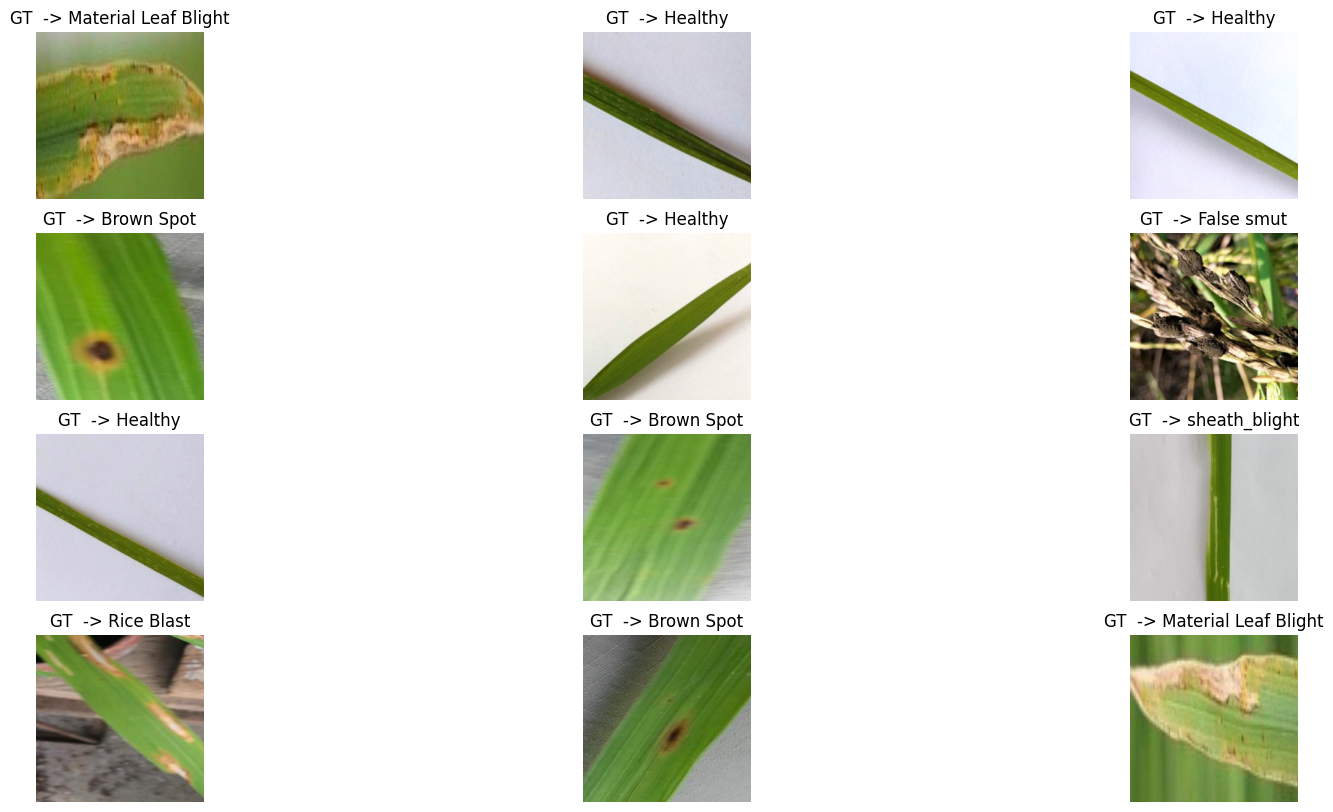

In [7]:
import random
from matplotlib import pyplot as plt
def tensor_2_pic(t, t_type = "rgb"):
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs
    return (invTrans(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8)
    

def visualization(data, num_pics, num_rows, cmap = None, class_names = None):
    assert cmap in ["gray", "rgb"]
    if cmap=="rgb": cmap = "viridis"

    plt.figure(figsize = (20,10))
    indexes = [random.randint(0, len(data) - 1) for _ in range(num_pics)]
    for idx, indeks in enumerate(indexes):
        pic, gt = data[indeks]
        plt.subplot(num_rows, num_pics // num_rows, idx+1)
        if cmap: plt.imshow(tensor_2_pic(pic, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_pic(pic))
        plt.axis("off")
        if class_names is not None: plt.title(f"GT  -> {class_names[gt]}")
        else: plt.title(f"GT -> {gt}")
visualization(data = tr_dl.dataset, num_pics = 12, num_rows = 4, cmap = "rgb", class_names = list(class_names.keys()))

### Number of Images in each Class

{'Brown Spot': 0, 'False smut': 1, 'Healthy': 2, 'Material Leaf Blight': 3, 'Rice Blast': 4, 'sheath_blight': 5, 'Stem rot': 6, 'Tungro': 7}


{'Brown Spot': 51, 'False smut': 97, 'Healthy': 100, 'Material Leaf Blight': 45, 'Rice Blast': 54, 'sheath_blight': 98, 'Stem rot': 85, 'Tungro': 65}


C:\Users\Nodir\AppData\Local\Temp\ipykernel_10368\1098528343.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation = 60)


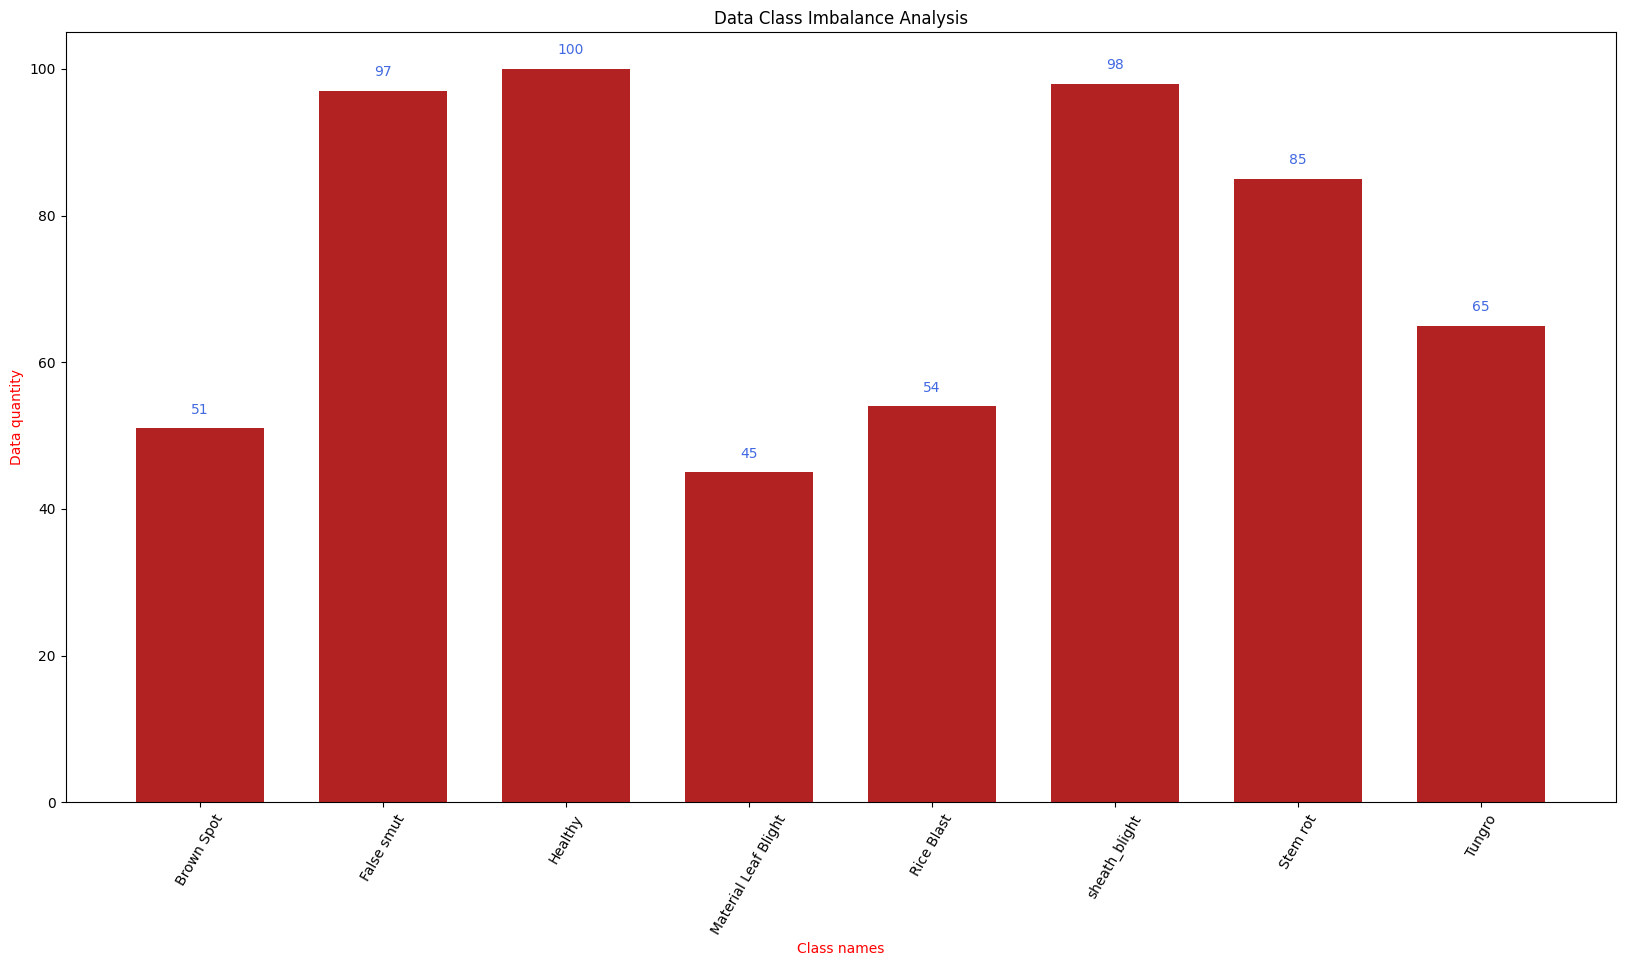

In [8]:
def  data_analysis(data_path, transformations):
    ds = CustomDataset(data_path = data_path, transformations = tfs)
    width = 0.7
    text_width = 0.05
    text_height = 2
    data_quantity = ds.data_quantity
    class_names = list(data_quantity.keys())
    counts = list(data_quantity.values())
    fig, ax = plt.subplots(figsize = (20, 10))
    indexes = np.arange(len(counts))
    ax.bar(indexes, counts, width, color = "firebrick")
    ax.set_xticklabels(class_names, rotation = 60)
    ax.set(xticks = indexes, xticklabels = class_names)
    ax.set_xlabel("Class names",   color = "red")
    ax.set_ylabel("Data quantity", color = "red")
    ax.set_title(f"Data Class Imbalance Analysis")
    for i, v in enumerate(counts):
        ax.text(i-text_width, v+text_height, str(v), color = "royalblue")
data_analysis(data_path = data_path, transformations = tfs)

### Train Phase

In [9]:
import timm
class TrainValidation:
    def __init__(self, model, class_names, tr_dl, vl_dl, device, patience,epochs, ds, folder_2_save = "best_model", lr = 3e-4 ):
        self.model = model
        self.class_names  = class_names
        self.tr_dl        = tr_dl
        self.vl_dl        = vl_dl
        self.device       = device
        self.lr           = lr
        self.epochs       = epochs
        self.patience     = patience
        self.folder_2_save= folder_2_save
        self.best_acc     = 0
        self.not_improved = 0
        
        
        self.model      = timm.create_model(model, pretrained = True, num_classes = len(self.class_names)).to(device)
        
        # class_counts = torch.tensor(list(ds.data_quantity.values()), dtype=torch.float)
        # weights = 1.0 / class_counts
        # weights = weights / weights.sum()
        # weights = weights.to(device)

        self.loss_fn    = torch.nn.CrossEntropyLoss(weight = weights)
        
        self.optimizer  = torch.optim.Adam(params = self.model.parameters(), lr = lr)
        self.f1_metric = torchmetrics.F1Score(task = "multiclass", num_classes = len(self.class_names)).to(device)

        self.train_losses, self.validation_losses   = [], []
        self.train_acces, self.validation_acces     = [], []
        self.train_f1score, self.validation_f1score = [], []

        os.makedirs(folder_2_save, exist_ok = True)

    @staticmethod
    def to_device(batch, device): return batch[0].to(device), batch[1].to(device)

    def do_train(self):
        self.model.train()
        train_acc, train_loss = 0, 0
        self.f1_metric.reset()
        
        for batch in tqdm(self.tr_dl, desc = "Training process..."):
            pics, labels = TrainValidation.to_device(batch = batch, device = self.device)
            preds   = self.model(pics)
            tr_loss = self.loss_fn(preds, labels)
            
            self.optimizer.zero_grad()
            tr_loss.backward()
            self.optimizer.step()
            
            train_loss += tr_loss.item()
            train_acc  += torch.sum(torch.argmax(preds, dim=1) == labels).item()
            self.f1_metric.update(preds, labels)

        train_loss /= len(self.tr_dl)
        train_acc   = (train_acc / len(self.tr_dl.dataset)) * 100
        train_f1    = self.f1_metric.compute().item()

        self.train_losses.append(train_loss)
        self.train_acces.append(train_acc)
        self.train_f1score.append(train_f1)
        return train_loss, train_acc, train_f1

    def do_validation(self):
        self.model.eval()
        vl_loss, vl_acc = 0, 0
        self.f1_metric.reset()
        with torch.no_grad():
            
            for batch in tqdm(vl_dl, desc = "Validation precess..."):
                pics, labels = TrainValidation.to_device(batch = batch, device = self.device)
                preds = self.model(pics)
                loss  = self.loss_fn(preds, labels)

                vl_loss += loss.item()
                vl_acc  += (torch.argmax(preds, dim=1) == labels).sum().item()
                self.f1_metric.update(preds, labels)

        vl_loss /= len(self.vl_dl)
        vl_acc = (vl_acc / len(self.vl_dl.dataset)) * 100
        vl_f1 = self.f1_metric.compute().item()

        self.validation_losses.append(vl_loss)
        self.validation_acces.append(vl_acc)
        self.validation_f1score.append(vl_f1)
        return vl_loss, vl_acc, vl_f1

    def results(self, epoch, metric1, metric2, metric3, process):
        print(f"{epoch+1}/{self.epochs}")
        print(f"For {epoch +1} epoch {process} loss    -> {metric1:.2f}")
        print(f"For {epoch+1} epoch {process} accuracy -> {metric2:.2f}%")
        print(f"For {epoch+1} epoch {process} score    -> {metric3:.2f}")
    def run(self):
        print(f"Training is about to start...")
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch+1}/{self.epochs}:\n")
            
            train_loss, train_acc, train_f1 = self.do_train()
            self.results(epoch, train_loss, train_acc, train_f1, process = "Train")
            
            vl_loss, vl_acc, vl_f1 = self.do_validation()
            self.results(epoch, vl_loss, vl_acc, vl_f1, process = "Validation")
            
            if vl_acc > self.best_acc:
                self.best_acc = vl_acc
                torch.save(self.model.state_dict(), os.path.join(self.folder_2_save, "Leaf_best_model"))
            else: self.not_improved += 1
            if self.not_improved == self.patience:
                print(f"Best validation accuracy has not changed over {self.patience} epochs. So the training staopped.")
                print(f"Models best accuracy is - {self.best_acc:.2f}")
                break

In [10]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
class_counts = torch.tensor(list(ds.data_quantity.values()), dtype=torch.float)
weights = 1.0 / class_counts
weights = weights / weights.sum()
weights = weights.to(device)

model = "rexnet_150"
device = "cuda" if torch.cuda.is_available() else 'cpu'
trainer = TrainValidation(model = model, tr_dl=tr_dl, vl_dl =  vl_dl, class_names = class_names, patience = 5, ds = ds, folder_2_save ="best_model", epochs=30, device = device)
trainer.run()

Training is about to start...

Epoch 1/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.12s/it]


1/30
For 1 epoch Train loss    -> 1.29
For 1 epoch Train accuracy -> 67.44%
For 1 epoch Train score    -> 0.67


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


1/30
For 1 epoch Validation loss    -> 0.28
For 1 epoch Validation accuracy -> 93.22%
For 1 epoch Validation score    -> 0.93

Epoch 2/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.06s/it]


2/30
For 2 epoch Train loss    -> 0.05
For 2 epoch Train accuracy -> 98.74%
For 2 epoch Train score    -> 0.99


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


2/30
For 2 epoch Validation loss    -> 0.21
For 2 epoch Validation accuracy -> 98.31%
For 2 epoch Validation score    -> 0.98

Epoch 3/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.06s/it]


3/30
For 3 epoch Train loss    -> 0.01
For 3 epoch Train accuracy -> 99.79%
For 3 epoch Train score    -> 1.00


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


3/30
For 3 epoch Validation loss    -> 0.24
For 3 epoch Validation accuracy -> 96.61%
For 3 epoch Validation score    -> 0.97

Epoch 4/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.05s/it]


4/30
For 4 epoch Train loss    -> 0.01
For 4 epoch Train accuracy -> 99.79%
For 4 epoch Train score    -> 1.00


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


4/30
For 4 epoch Validation loss    -> 0.22
For 4 epoch Validation accuracy -> 98.31%
For 4 epoch Validation score    -> 0.98

Epoch 5/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


5/30
For 5 epoch Train loss    -> 0.01
For 5 epoch Train accuracy -> 100.00%
For 5 epoch Train score    -> 1.00


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]


5/30
For 5 epoch Validation loss    -> 0.21
For 5 epoch Validation accuracy -> 98.31%
For 5 epoch Validation score    -> 0.98

Epoch 6/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.04s/it]


6/30
For 6 epoch Train loss    -> 0.01
For 6 epoch Train accuracy -> 99.79%
For 6 epoch Train score    -> 1.00


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


6/30
For 6 epoch Validation loss    -> 0.21
For 6 epoch Validation accuracy -> 98.31%
For 6 epoch Validation score    -> 0.98

Epoch 7/30:



Training process...: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


7/30
For 7 epoch Train loss    -> 0.00
For 7 epoch Train accuracy -> 100.00%
For 7 epoch Train score    -> 1.00


Validation precess...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

7/30
For 7 epoch Validation loss    -> 0.22
For 7 epoch Validation accuracy -> 98.31%
For 7 epoch Validation score    -> 0.98
Best validation accuracy has not changed over 5 epochs. So the training staopped.
Models best accuracy is - 98.31


### Plot Learning Curves

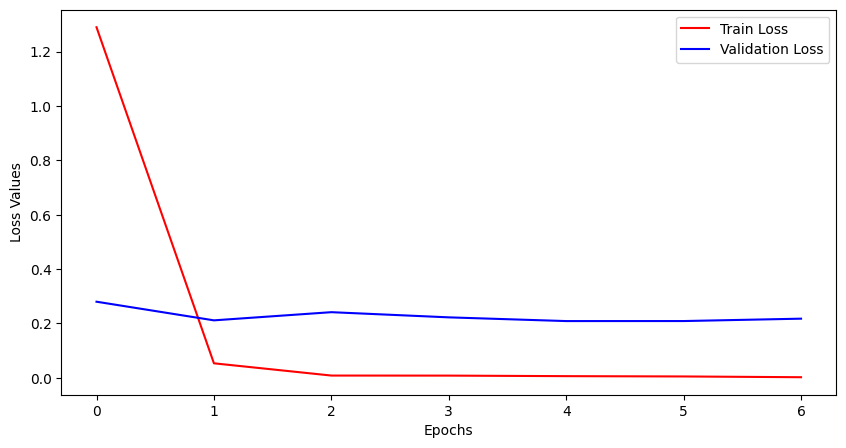

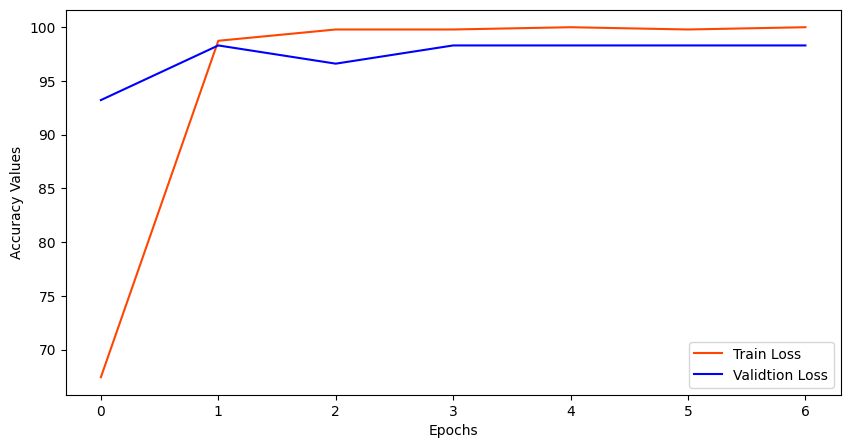

In [13]:
class PlotLearningCurves:
    def __init__(self, train_loss, train_acc, vl_loss, vl_acc):
        self.train_loss = train_loss
        self.train_acc  = train_acc
        self.vl_acc     = vl_acc
        self.vl_loss    = vl_loss

    def draw(self, array1, array2, label1, label2, color1, color2):
        plt.plot(array1, label = label1, c = color1)
        plt.plot(array2, label = label2, c = color2)

    def create_plot(self): return plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(ticks = np.arange(len(self.train_acc) +1), labels = [i for i in range(len(self.train_acc)+1)])
        plt.legend()
        plt.show()

    def demonstrate(self):
        self.create_plot()
        self.draw(array1 = self.train_loss, array2 = self.vl_loss, label1 = "Train Loss", label2 = "Validation Loss", color1 = "red", color2 = "blue"); self.decorate(ylabel = "Loss Values")

        self.create_plot()
        self.draw(array1 = self.train_acc, array2 = self.vl_acc, label1 = "Train Loss", label2 = "Validtion Loss", color1 = "orangered", color2 = "blue"); self.decorate(ylabel = "Accuracy Values")
        

PlotLearningCurves(train_loss = trainer.train_losses, train_acc = trainer.train_acces, vl_loss = trainer.validation_losses, vl_acc = trainer.validation_acces).demonstrate()

### Inference

In [15]:
import random
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2, seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import cv2
import seaborn as sns

In [103]:
class Denormalize:
    def __init__(self, mean = mean, std = std):
        self.mean = mean 
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            return t.mul_(s).add_(m)

class Inference:
    def __init__(self, model, device, class_names, img_size = 224, mean = mean, std=std):
        self.denormalize = Denormalize(mean=mean, std = std)
        self.model = model
        self.model.eval()
        self.img_size = img_size
        self.class_names = class_names
        self.device = device

    def tensor_2_pic(self, tensor):
        tensor = self.denormalize(tensor)
        tensor = tensor.unsqueeze(0)
        tensor = tensor.permute(1,2, 0)
        return (tensor.cpu().numpy() *255).astype(np.uint8)

    def gradcam(self, pic):
        cam = GradCAMPlusPlus(self.model, target_layers = [self.model.features[-1]], use_cuda = True)
        final_cam = cam(pic.unsqueeze(0))[0, :]
        return final_cam

    def inference(self, model, ts_dl, num_of_pics, num_rows):
        images, predictions, prediction_classes, ground_truth = [], [], [], []
        accuracy = 0
        amount = 1
        with torch.no_grad():
            
            for idx, batch in tqdm(enumerate(ts_dl), desc = "Train process ... "):
                pic, label = TrainValidation.to_device(batch = batch, device = self.device)
                pred = self.model(pic)
                pred_class = torch.argmax(pred, dim=1)

                accuracy += (pred_class == label).sum().item()

                images.append(pic[0])
                predictions.append(pred[0])
                prediction_classes.append(pred_class[0].item())
                ground_truth.append(label[0].item())

            print(f"Test accuracy is ->  {(accuracy/len(ts_dl.dataset)) * 100:.2f}")

        plt.figure(figsize = (20,10))
        indexes = [random.randint(0, len(images) - 1) for _ in range(num_of_pics)]
        for idx, element in enumerate(indexes): # element emas element
            
            pic = self.tensor_2_pic(images[element].squeeze())
            pred_element = (prediction_classes[element])
            ground_truth_element = (ground_truth[element])

            plt.subplot(num_rows, num_of_pics // num_rows, amount)
            amount += 1
            plt.imshow(pic, cmap = "gray")
            plt.axis("off")

            cam_pic = self.gradcam(images[element])
            tablot = show_cam_on_image(pic / 255, cam_pic, image_weight = 0.4, use_rgb = True)
            plt.imshow(cv2.resize(tablot, (self.img_size, self.img_size), interpolation = cv2.INTER_LINEAR), alpha = 0.7, cmap = "jet")
            plt.axis("off")

            pred = predictions[element]
            if pred.dim() == 1: pred = pred.unsqueeze(0)

            if self.class_names:
                label_name = self.class_names[ground_truth_element]
                pred_name = self.class_names[pred_element]
                col = "green" if pred_name == label_name else "red"
                plt.title(f"Original image name - {label_name}; Prediction name - {pred_name}", color = col)
        plt.figure(figsize=(8, 6))   
        num_classes = len(self.class_names)
        cm = confusion_matrix(ground_truth, prediction_classes, labels=range(num_classes))

        plt.figure(figsize=(18, 8))   
        sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", 
        xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Bashoratlar")
        plt.ylabel("Ground truths")
        plt.show()               

                

        

C:\Users\Nodir\AppData\Local\Temp\ipykernel_10368\3574749944.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model/Leaf_best_model

Test accuracy is ->  95.00


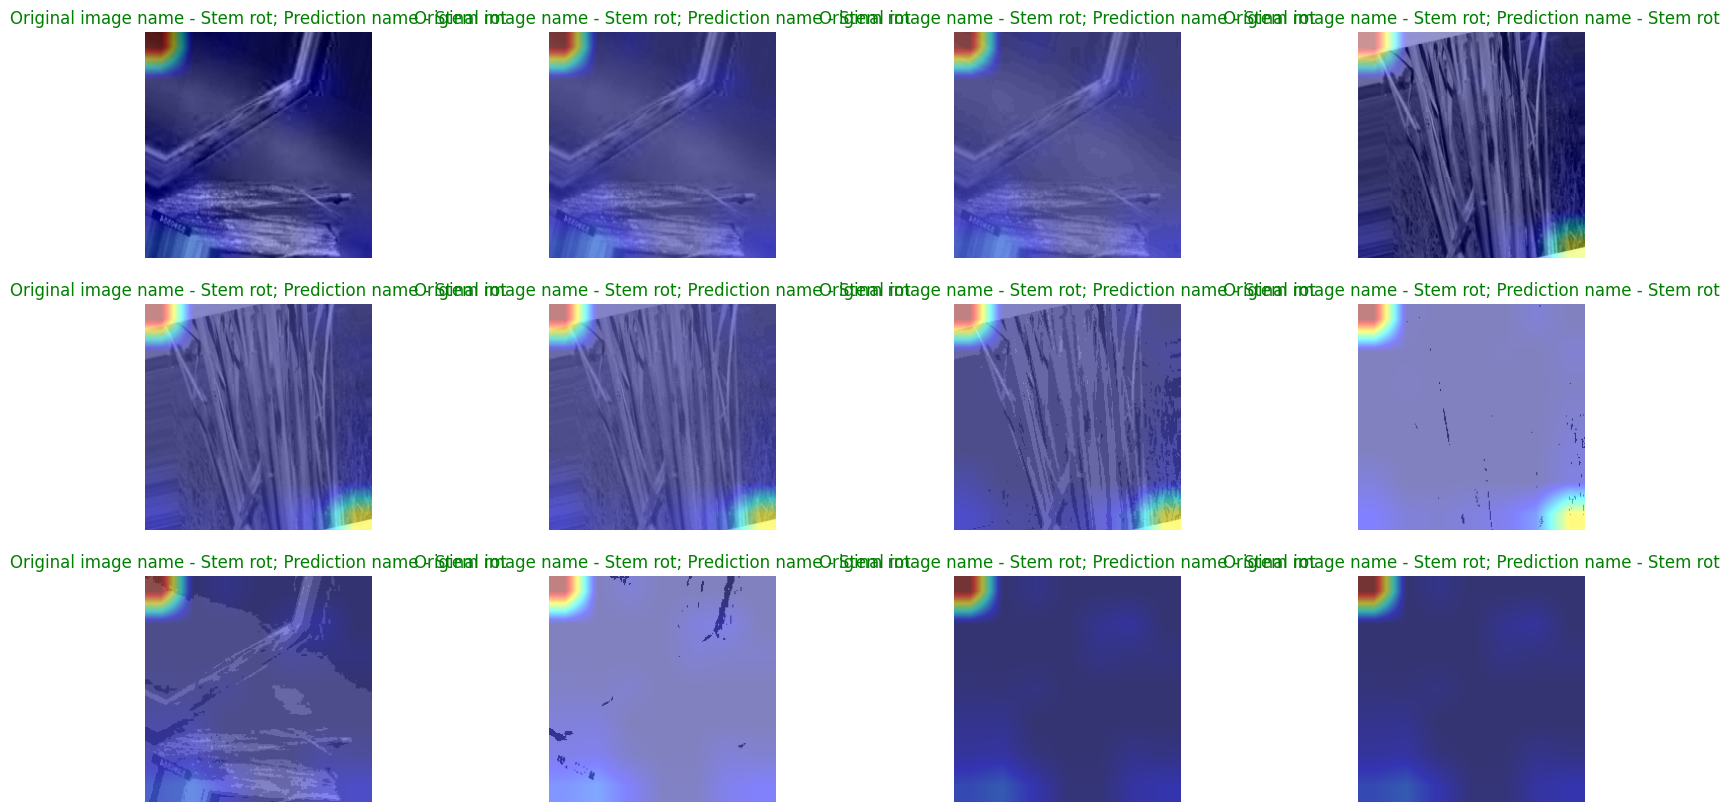

<Figure size 800x600 with 0 Axes>

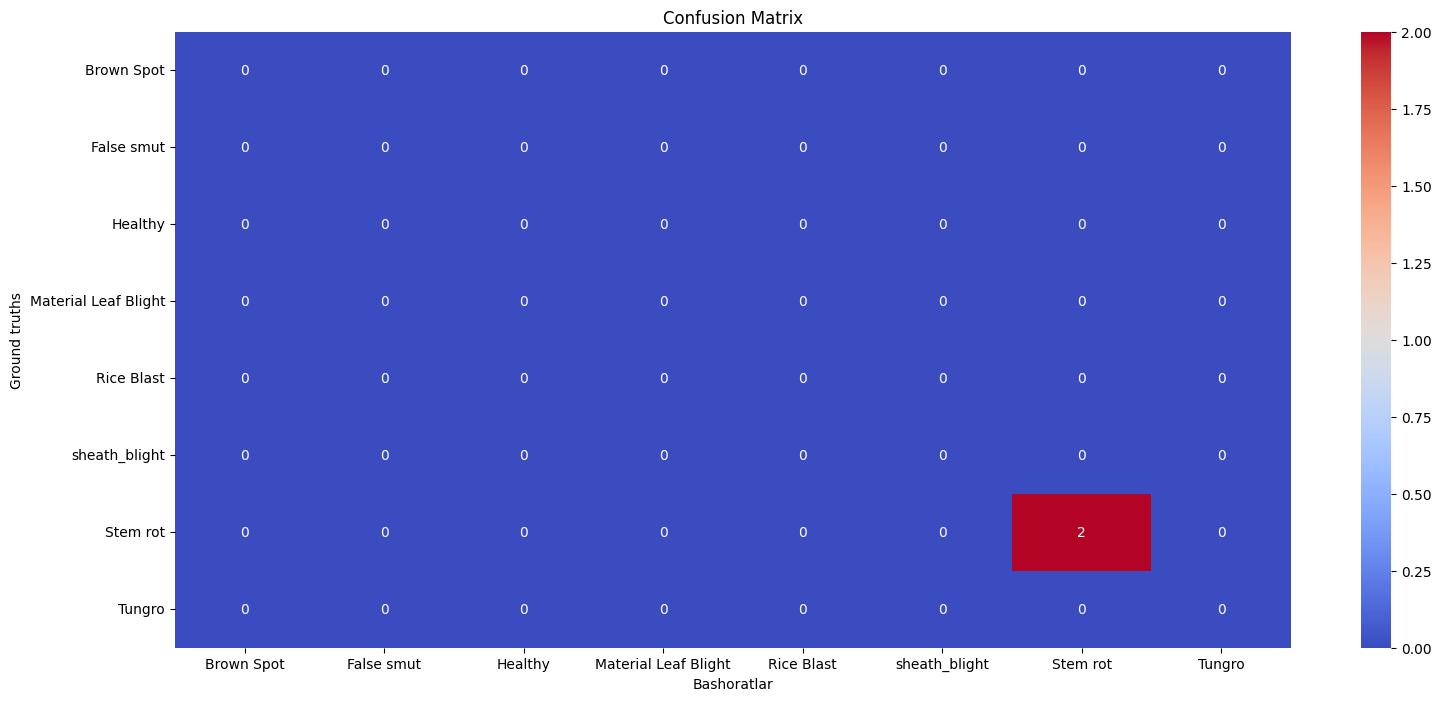

In [105]:
device = "cuda"
model = timm.create_model(model_name = "rexnet_150", pretrained = False, num_classes = len(class_names)).to(device)
model.load_state_dict(torch.load("best_model/Leaf_best_model"))
drawer = Inference(model=model, device=device, class_names=list(class_names.keys()), img_size=224)

drawer.inference(model= model, ts_dl = ts_dl, num_of_pics=12, num_rows=3)